_Version log: Investigating the Hartley Transform_

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as spfft

c = 299_800_000

def narrowband(x, wavelength): #NARROWBAND
    wavenumber = 2*np.pi/wavelength #angular wavenumber
    return np.sin(wavenumber*x)
   
def gaussian(x, mean, sigma):
    return (1 /(sigma *(2*np.pi)**0.5)) *np.exp(-(1/2) *(x -mean)**2 /(sigma**2))

def broadband(x, central_wavenumber, FWHM, sinosoid= "sin"): #BROADBAND
    niquist = 2/1 # I'm using steps of 1 pixel
    k = np.linspace(-niquist, niquist, len(x))
    amplitudes = gaussian(k, central_wavenumber, (8 *np.log(2))**-0.5 *FWHM)
    x, k = np.meshgrid(x, k)

    if sinosoid == "sin":
        sinosoidal_waves = amplitudes * np.sin(k*x /2/np.pi)
    elif sinosoid == "cos":
        sinosoidal_waves = amplitudes * np.cos(k*x /2/np.pi)
    else:
        raise ValueError("{0:} is not a regnosed sinosoid.".format(sinosoid))

    sinosoidal_waves = np.sum(sinosoidal_waves, axis = 1)
    return sinosoidal_waves

In [70]:
array_length = 999 #in pixels
aspect_ratio = 3/4 # 1:1 for pyro, 4:5 for purple, 3:4 for xeva and manta
wavenumber = 1.5 #in pixels^-1
bandwidth = 1 #in pixels^-1

x = np.arange(-array_length//2, array_length//2)

y = broadband(x, wavenumber, bandwidth, sinosoid= "cos")

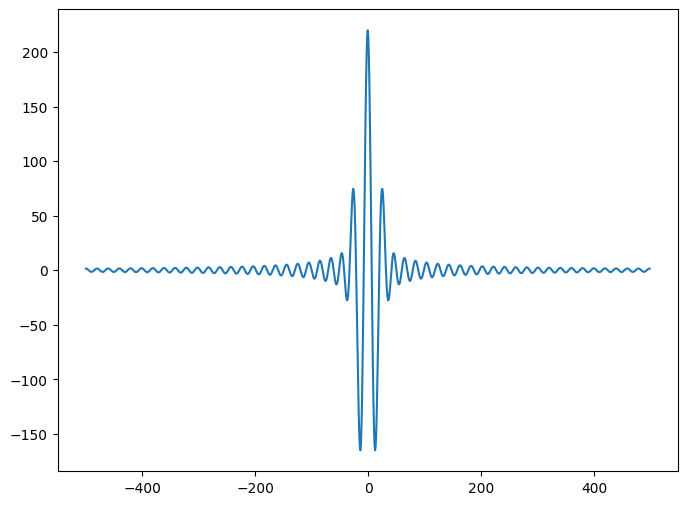

In [71]:
plt.figure(figsize=(8,6))

plt.plot(x, y)

plt.show()
#np.savetxt("1d_mock_interferogram.csv", y, delimiter=",")

In [194]:
def dht(x): #I stole this from stack exchange
    y = np.fft.rfft(x, norm= "forward")
    y = np.real(y) - np.imag(y)
    return y

def idht(x): #I stole this from stack exchange
    y = dht(x) #dht = idht
    return y

def crfft(x): #custom real fast fourier transform.
    ft = np.fft.rfft(x, norm= "forward", axis= -1)
    real = np.real(ft)

    imag = np.imag(ft)[..., 1:] #0 frequency means the average. because x is real, the imaginary component of the average is always 0.

    return np.concatenate([real, np.flip(imag, axis=-1)], axis= -1)

def icrfft(x, length= None):
    real, imag = np.split(x, [int(np.ceil(x.shape[-1]/2))], axis= -1)

    if x.ndim == 1:
        imag = np.concatenate([[0], np.flip(imag)])
    elif x.ndim == 2:
        imag = np.concatenate([[[0]]*imag.shape[0], np.flip(imag, axis=-1)], axis= -1)
    else:
        raise IndexError("Expected 1 or 2 dimentions. Got {0:}".format(x.ndim))
    
    ft = real + 1j*imag

    return np.fft.irfft(ft, n=length, norm= "forward", axis= -1)

print(len(y))
print(len(crfft(y)))
print(len(icrfft(crfft(y))))

999
999
998


In [206]:
np.eye(4,3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

(9, 9)
(9, 9)
(9, 9)


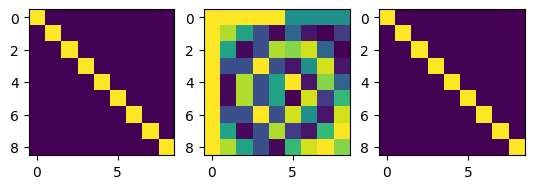

In [204]:
matrix1 = np.eye(9)
matrix2 = crfft(matrix1)
matrix3 = icrfft(matrix2, length= matrix1.shape[-1])

fig, axs = plt.subplots(1,3)

axs[0].imshow(matrix1, interpolation= "nearest")
print(matrix1.shape)
axs[1].imshow(matrix2, interpolation= "nearest")
print(matrix2.shape)
axs[2].imshow(matrix3, interpolation= "nearest")
print(matrix3.shape)

plt.show()

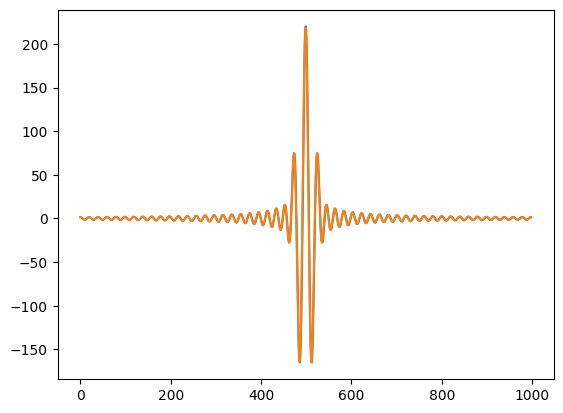

In [197]:
plt.plot(y)
plt.plot(icrfft(crfft(y)))
plt.show()

In [198]:
FFT = np.fft.rfft(y, norm= "forward")
DHT = dht(y)
DCT = spfft.dct(y, norm= "forward")
DST = spfft.dst(y, norm= "forward")
CFT = crfft(y)

print("RFFT: {0:d} \nDHT {1:d} \nDCT: {2:d} \nDST: {3:d} \nCFT: {4:d}".format(len(FFT), len(DHT), len(DCT), len(DST), len(CFT)))

RFFT: 500 
DHT 500 
DCT: 999 
DST: 999 
CFT: 999


In [199]:
CFT.max()

4.600577037610855

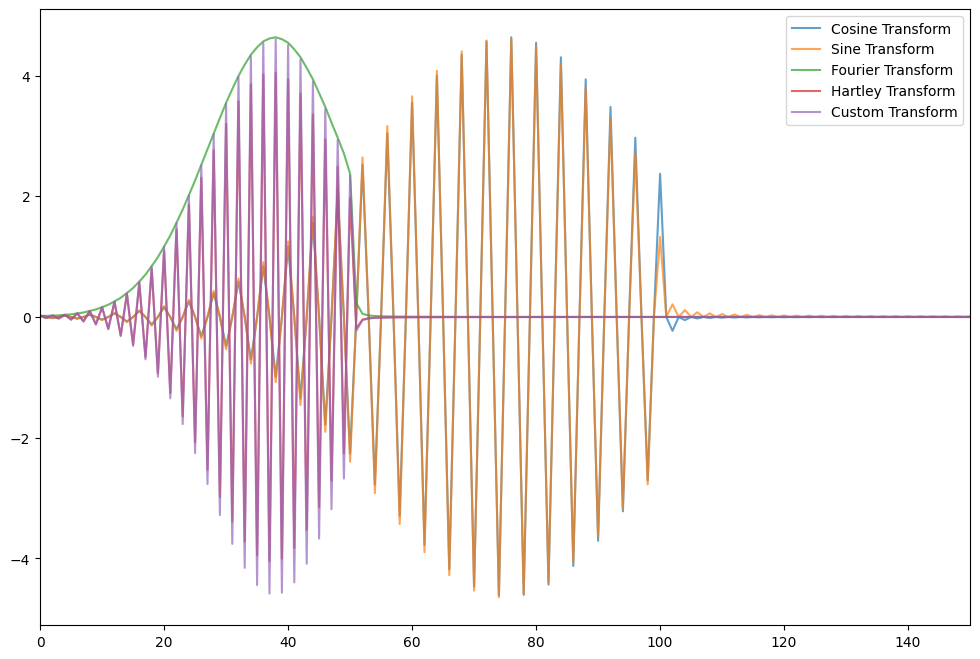

In [200]:
plt.figure(figsize= (12,8))

plt.plot(DCT, label= "Cosine Transform", alpha= 0.7)
plt.plot(DST, label= "Sine Transform", alpha= 0.7)
plt.plot(np.abs(FFT), label= "Fourier Transform", alpha= 0.7)
plt.plot(DHT, label= "Hartley Transform", alpha= 0.7)
plt.plot(CFT, label= "Custom Transform", alpha= 0.7)

plt.xlim(0, 150)
plt.legend()
plt.show()